* Openpose (+gamma) without background and frame difference as input. Addition as combination

* preConvLSTM of 3 filters

In [1]:
# Use output of OpenPose with or without background
BACKGROUND = False
# Paths to videos for training
PATHS = ["../../../datasets/RWF-2000", f"../../../datasets/openpose_processed/gamma/{'' if BACKGROUND else 'no_'}back"]

FRAME_FUNC = 'frame_diff'
# To use frame diff to weight t (current) or t+1
WEIGHT_CURRENT = True

In [2]:
import tensorflow as tf

In [3]:
!export TF_FORCE_GPU_ALLOW_GROWTH=True
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.set_visible_devices(gpus[1:], 'GPU')

2022-05-13 05:44:18.616644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 05:44:18.618701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 05:44:18.619733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 05:44:18.625146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 05:44:18.627244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Set seed

In [4]:
SEED = 0
import random
import numpy as np
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load data

In [5]:
import numpy as np
import cv2

In [6]:
ORIGINAL_FRAMES_PER_VIDEO = 150
FRAMES_PER_VIDEO = 50 + 1
VIDEO_WIDTH, VIDEO_HEIGHT = 100, 100
N_CHANNELS = 3

def load_videos(video_IDs: list, video_frames: int = FRAMES_PER_VIDEO, video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False) -> tuple:
    videos = np.empty((len(video_IDs), video_frames, video_height, video_width, video_channels), dtype=dtype)

    # Indexes of frames to be kept to comply with video_frames
    frames_idx = set(np.round(np.linspace(0, ORIGINAL_FRAMES_PER_VIDEO - 1, video_frames)).astype(int))

    for i, video_ID in enumerate(video_IDs):
        cap = cv2.VideoCapture(video_ID)
        frames = []
        index = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if index in frames_idx:
                frame = cv2.resize(frame, (video_width, video_height)).astype(dtype)
                if normalize:
                    frame /= 255.0
                frames.append(frame)
            index += 1
        cap.release()

        videos[i,] = np.array(frames)

    return videos

DataGenerator class to load videos per batch, in case all videos do not fit in memory

In [7]:
import gc
from tensorflow.keras import backend as K

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_IDs: list, video_labels: dict, batch_size: int, paths: list = [''], video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_frames: int = FRAMES_PER_VIDEO, video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False, shuffle: bool = True):
        self.video_IDs = video_IDs
        self.video_labels = video_labels
        self.batch_size = batch_size
        self.paths = paths
        self.video_width = video_width
        self.video_height = video_height
        self.video_frames = video_frames
        self.video_channels = video_channels
        self.dtype = dtype
        self.normalize = normalize
        self.shuffle = shuffle

    def __len__(self):
        return len(self.video_IDs) // self.batch_size

    def __getitem__(self, idx):
        batch_IDs = self.video_IDs[idx*self.batch_size:(idx+1)*self.batch_size]
        input_videos = []
        
        for index, path in enumerate(self.paths):
            batch_IDs_full_path = [path+ID for ID in batch_IDs]

            videos = load_videos(batch_IDs_full_path, self.video_frames, self.video_width, 
                                         self.video_height, self.video_channels, self.dtype, self.normalize)
            
            input_videos.append(videos)
        
        labels = np.array([self.video_labels[ID] for ID in batch_IDs])
                    
        return input_videos, labels
            
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.video_IDs)
        # Clear memory after epochs
        gc.collect()
        #K.clear_session()

## Videos to load

In [8]:
def get_slug_from_path(path):
    """
    Function to get slug from path
    slug must contain /train or /val because there are repeated names
    """
    # Try train index first
    index = path.rfind('/train/')
    if index == -1:
        index = path.rfind('/val/')
    return path[index:]

In [9]:
import glob

train_video_IDs = [get_slug_from_path(path) for path in glob.glob(PATHS[0]+'/train/*/*')]
test_video_IDs = [get_slug_from_path(path) for path in glob.glob(PATHS[0]+'/val/*/*')]

train_video_labels = {video: 0 if 'NonFight' in video else 1 for video in train_video_IDs}
test_video_labels = {video: 0 if 'NonFight' in video else 1 for video in test_video_IDs}


train_generator = DataGenerator(train_video_IDs, train_video_labels, batch_size=10, paths=PATHS)
test_generator = DataGenerator(test_video_IDs, test_video_labels, batch_size=10, paths=PATHS)

# Frame functions

In [10]:
import tensorflow.keras.backend as K

def tf_frame_diff(video):
    return video[1:] - video[:-1]

def tf_frame_dist(video):
    video_diff = tf_frame_diff(video)
    return K.sqrt(K.sum(K.square(video_diff), axis=-1, keepdims=True))

if WEIGHT_CURRENT:
    def tf_frame_diff_dist_combined(video):
        video_diff = tf_frame_diff(video)
        video_diff_current = tf.nn.relu(-video_diff)
        video_diff_next = tf.nn.relu(video_diff)
        video_diff_next_norm = K.sqrt(K.sum(K.square(video_diff_next), axis=-1, keepdims=True))
        return K.concatenate([video_diff_current, video_diff_next_norm])
else:
    def tf_frame_diff_dist_combined(video):
        video_diff = tf_frame_diff(video)
        video_diff_current = tf.nn.relu(video_diff)
        video_diff_prev = tf.nn.relu(-video_diff)
        video_diff_prev_norm = K.sqrt(K.sum(K.square(video_diff_prev), axis=-1, keepdims=True))
        return K.concatenate([video_diff_current, video_diff_prev_norm])
    
frame_func_dict = {'frame_diff': tf_frame_diff, 'frame_dist': tf_frame_dist, 'frame_diff_dist_combined': tf_frame_diff_dist_combined}
frame_func = frame_func_dict[FRAME_FUNC]

# ConvLSTM

In [11]:
inputs_raw = tf.keras.layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))
inputs_openpose = tf.keras.layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))

inputs_diff = tf.keras.layers.Lambda(lambda video: tf.map_fn(frame_func, video))(inputs_raw)
inputs_to_weight = inputs_openpose[:, :-1] if WEIGHT_CURRENT else inputs_openpose[:, 1:]

inputs_diff_norm = tf.keras.layers.BatchNormalization()(inputs_diff)
inputs_diff_time_info_weight = tf.keras.layers.ConvLSTM2D(filters=3, kernel_size=(3, 3), return_sequences=True, data_format='channels_last', activation='tanh')(inputs_diff_norm)

convolutional_layer = tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), activation='relu')
inputs_openpose_soft = tf.keras.layers.TimeDistributed(convolutional_layer)(inputs_to_weight)

inputs_openpose_norm = tf.keras.layers.BatchNormalization(scale=False, center=False)(inputs_openpose_soft)

inputs_weighted = tf.keras.layers.Add()([inputs_openpose_norm, inputs_diff_time_info_weight])

x = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), return_sequences=False, data_format='channels_last', activation='tanh')(inputs_weighted)

x = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')(x)

x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dense(units=16, activation='relu')(x)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

model = tf.keras.Model([inputs_raw, inputs_openpose], outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 51, 100, 10  0           []                               
                                0, 3)]                                                            
                                                                                                  
 input_1 (InputLayer)           [(None, 51, 100, 10  0           []                               
                                0, 3)]                                                            
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 50, 100, 100  0          ['input_2[0][0]']                
 ingOpLambda)                   , 3)                                                          

2022-05-13 05:44:18.720407: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-13 05:44:18.948044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 05:44:18.949069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 05:44:18.949486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [12]:
history = model.fit(train_generator, epochs=30, validation_data=test_generator, verbose=2)

Epoch 1/30


2022-05-13 05:44:28.540870: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-05-13 05:44:29.572097: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-05-13 05:44:29.573925: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2022-05-13 05:44:29.573955: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-05-13 05:44:29.574080: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

160/160 - 523s - loss: 0.6978 - accuracy: 0.5081 - val_loss: 0.6931 - val_accuracy: 0.5000 - 523s/epoch - 3s/step
Epoch 2/30
160/160 - 532s - loss: 0.6793 - accuracy: 0.5519 - val_loss: 0.6092 - val_accuracy: 0.7075 - 532s/epoch - 3s/step
Epoch 3/30
160/160 - 532s - loss: 0.5908 - accuracy: 0.6869 - val_loss: 0.5030 - val_accuracy: 0.7675 - 532s/epoch - 3s/step
Epoch 4/30
160/160 - 533s - loss: 0.5119 - accuracy: 0.7494 - val_loss: 0.4486 - val_accuracy: 0.8100 - 533s/epoch - 3s/step
Epoch 5/30
160/160 - 531s - loss: 0.4763 - accuracy: 0.7806 - val_loss: 0.4190 - val_accuracy: 0.8100 - 531s/epoch - 3s/step
Epoch 6/30
160/160 - 533s - loss: 0.4419 - accuracy: 0.8037 - val_loss: 0.4175 - val_accuracy: 0.8150 - 533s/epoch - 3s/step
Epoch 7/30
160/160 - 530s - loss: 0.4462 - accuracy: 0.7987 - val_loss: 0.3812 - val_accuracy: 0.8475 - 530s/epoch - 3s/step
Epoch 8/30
160/160 - 532s - loss: 0.4198 - accuracy: 0.8175 - val_loss: 0.3760 - val_accuracy: 0.8475 - 532s/epoch - 3s/step
Epoch 9/30


# Model performance

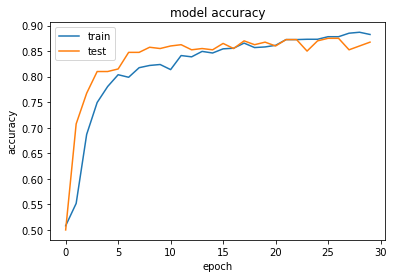

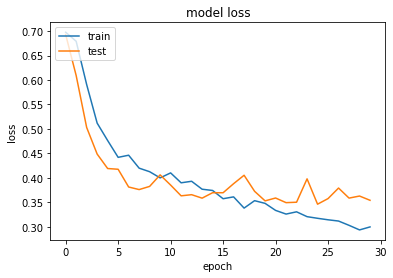

In [13]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save perfomance metrics

In [14]:
import os
import ipynbname
import json
from keras.utils.layer_utils import count_params

current_directory = os.getcwd() + '/'
results_directory = current_directory.replace('notebooks', 'results_summary')

experiment_name = ipynbname.name()

# Save history as json
with open(results_directory + experiment_name + '.json', 'w') as f:
    json.dump(history.history, f)
    
# Compute max val_accuracy and number of trainable params and append to stats
max_val_acc = max(history.history['val_accuracy'])
trainable_params = count_params(model.trainable_weights)

# Store value in latex table format
acc_string = f'{experiment_name} & {max_val_acc:.2%}'.replace('%', '\%')
acc_params_string = acc_string + f' & {trainable_params}'

with open(results_directory + 'acc.dat', 'a') as f:
    f.write(acc_string + ' \\\ \n')
    
with open(results_directory + 'acc_params.dat', 'a') as f:
    f.write(acc_params_string + ' \\\ \n')